In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import scipy as sp
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline

In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Using polar coordinates centered on the lens galaxy, the combined lens potential can be written as

$$\phi (r, \theta) = b r f(\theta) + \frac{r^2}{2} (\gamma_c \cos{2 \theta} + \gamma_s \sin{2 \theta} )$$

where

$$f(\theta) = \left[ 1 - \epsilon \cos{2 ( \theta - \theta_0)} \right]^{1/2}$$

The deflection vector $\nabla \phi$ has cartesian components 

\begin{gather}
\nabla_x \phi = \frac{b}{f(\theta)} [\cos \theta - \epsilon \cos{(\theta - 2 \theta_0)}] + \gamma_c r \cos \theta + \gamma_s r \sin \theta \\
\nabla_y \phi = \frac{b}{f(\theta)} [\sin \theta - \epsilon \sin{(\theta - 2 \theta_0)}] + \gamma_s r \cos \theta - \gamma_c r \sin \theta
\end{gather}

The gravitational lens equation has the form

$$\vec{u} = \vec{x} - \nabla \phi (\vec{x})$$

which is really a set of two equations.
\begin{gather}
u = x - \nabla_x \phi (\vec{x}) \\
v = y - \nabla_y \phi (\vec{x})
\end{gather}
We need a penalty function $\chi^2$ that will determine the parameters $b, \epsilon, \gamma_c, \gamma_s, \theta_0$ in the lens potential $\phi$ and the parameters $u,v$, the position of the source. Let $\vec{x}_i, \sigma_i, \, i=0,1,2,3$ be the positions and uncertainties of the four images. Based on Keeton (2010, Gen.Rel.Grav., 42, 2151) we will define our $\chi^2$ function to be in the source plane. This eliminates the need for solving the lens equation (which is computationally expensive), and is a fine apprixmation given how small our uncertainties are. Let $\vec{\mu}_i = (\mu_i, \nu_i)$ be the position of the source as calculated from the lens equation using the $i$th image position. Then we can define our penalty function to be
$$ \chi^2 = \sum_{i=0}^3 \frac{1}{\sigma_i^2} \left( \vec{u} - \vec{\mu}_i \right)^2$$

In [47]:
def f(theta, eps, theta0): # defining f(θ)
    return (1 - eps * np.cos(2 * (theta - theta0)))**(1/2)

def phi(rtheta, b, eps, gc, gs, theta0): # ϕ
    r, theta = rtheta
    return b * r * f(theta, eps, theta0) + r**2 / 2 * ( gc * np.cos(2*theta) + gs * np.sin(2*theta))

def dxphi(rtheta, b, eps, gc, gs, theta0): # deflection vector x component
    r, theta = rtheta
    return b / f(theta, eps, theta0) * (np.cos(theta) - eps * np.cos( theta - 2 * theta0)) \
        + gc * r * np.cos(theta) + gs * r * np.sin(theta)


def dyphi(rtheta, b , eps, gc, gs, theta0): #deflection vector y component
    r, theta = rtheta
    return b / f(theta, eps, theta0) * (np.sin(theta) - eps * np.sin( theta - 2 * theta0)) \
        + gs * r * np.cos(theta) - gc * r * np.sin(theta)


def calcsource(params, rtheta): # calculates the source given the ϕ-params and an image position
    b, eps, gc, gs, theta0, _, _ = params
    r, theta = rtheta
    x, y = pol2cart(r, theta)
    mu = x - dxphi(rtheta, b, eps, gc, gs, theta0)
    nu = y - dyphi(rtheta, b, eps, gc, gs, theta0)
    return (mu, nu)

    
def lnprob(params, rthetasigma): # our χ^2 function
    b, eps, gc, gs, theta0, u, v = params
    r, theta, sigma = rthetasigma
    if b<0 or not 0<=eps<1 or not 0<=theta0<2*np.pi: return -np.inf
    chi2 = 0
    for i in range(len(r)):
        mu, nu = calcsource(params, (r[i], theta[i]))
        chi2 += ((u - mu)**2 + (v - nu)**2) / sigma[i]**2
    return -chi2 / 2 

Here we import the data from the file lensData.txt,  in which the data is stored as described

For each lens there should be 11 numbers 
First we have the uncertainty, then we have the dRA and dDec for the lensing galaxy
Then we have the dRA and dDec for each image (4 images each)
If we have 3 lenses, we should have 33 numbers in our chain, and so on...

In [28]:
file1 = open('lensData.txt','r')
Lines = file1.read().replace('\n',' ');


a= Lines.split(" ")

numLenses = 8
numImages = 4
oldData = np.zeros((numLenses,3,numImages))
newData = np.zeros((numLenses,3,numImages))

i=0
j=0
k=0
count=0;
while (i< numLenses):
    uncert= a[count]
    count=count+1;
    xChange=a[count]
    count=count+1
    yChange=a[count]
    count=count+1
    while (j< numImages):
        oldData[i][0][j] = float(a[count]) - float(xChange)
        count=count+1;
        oldData[i][1][j] = float(a[count]) - float(yChange)
        count=count+1;
        oldData[i][2][j]= float(uncert);
        j=j+1;
    i=i+1;
    j=0

    
i=0
j=0
k=0

while (i<numLenses):
    while (j<numImages):
        newData[i][2][j] = oldData[i][2][j]
        newData[i][0][j],newData[i][1][j] = cart2pol(oldData[i][0][j], oldData[i][1][j])
        j=j+1;
    i=i+1;
    j=0
    
#We now have our data stored as polar coordinates.
#In our array, we have a 3D array of length [8(number of lenses)][3(numer of paramters)][4(number of images)]
#In which we store the values for r and theta for each image, and then the uncertainty of the image
print(newData[0])

[[ 0.74886581  0.6705617   0.69442998  0.68654279]
 [-0.33188534 -2.13397987  1.02074512  2.41906303]
 [ 0.003       0.003       0.003       0.003     ]]


In [19]:
def mcmc_model(data, nwalk=20, nburn=100000, nmain=500000):
    ndim = 7
#     nwalk = 20
#     nburn = 100000
#     nmain = 500000

    # might be better to use this segment if we have a better idea of what the low and high values might be for each parameter
    # generate random starting points
    p0 = np.zeros((nwalk,ndim))
    for iwalk in range(nwalk):
        p0[iwalk,0] = np.random.uniform()
        p0[iwalk,1] = np.random.uniform()
        p0[iwalk,2] = np.random.uniform()
        p0[iwalk,3] = np.random.uniform()
        p0[iwalk,4] = np.random.uniform(low=0, high=2*np.pi)
        p0[iwalk,5] = np.random.uniform(low=-0.1, high=0.1)
        p0[iwalk,6] = np.random.uniform(low=-0.1, high=0.1)

#     pstart = np.zeros(ndim)
#     p0 = np.array([np.random.uniform(size=ndim) for i in range(nwalk)]) 
#     p0 = np.array([ pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk) ])


    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(data,)) 

    # burn-in run
#     pos,prob,state = sampler.run_mcmc(p0,nburn)

#     sampler.reset()

    pos = p0

    # main run
    res = sampler.run_mcmc(pos,nmain)
    samples = sampler.chain.reshape((-1,ndim))
    return samples

In [64]:
try:samples = mcmc_model(newData[0], nburn=5000, nmain=10000)
except: samples = mcmc_model(newData[0], nburn=5000, nmain=10000)

c:\python3_7_9\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


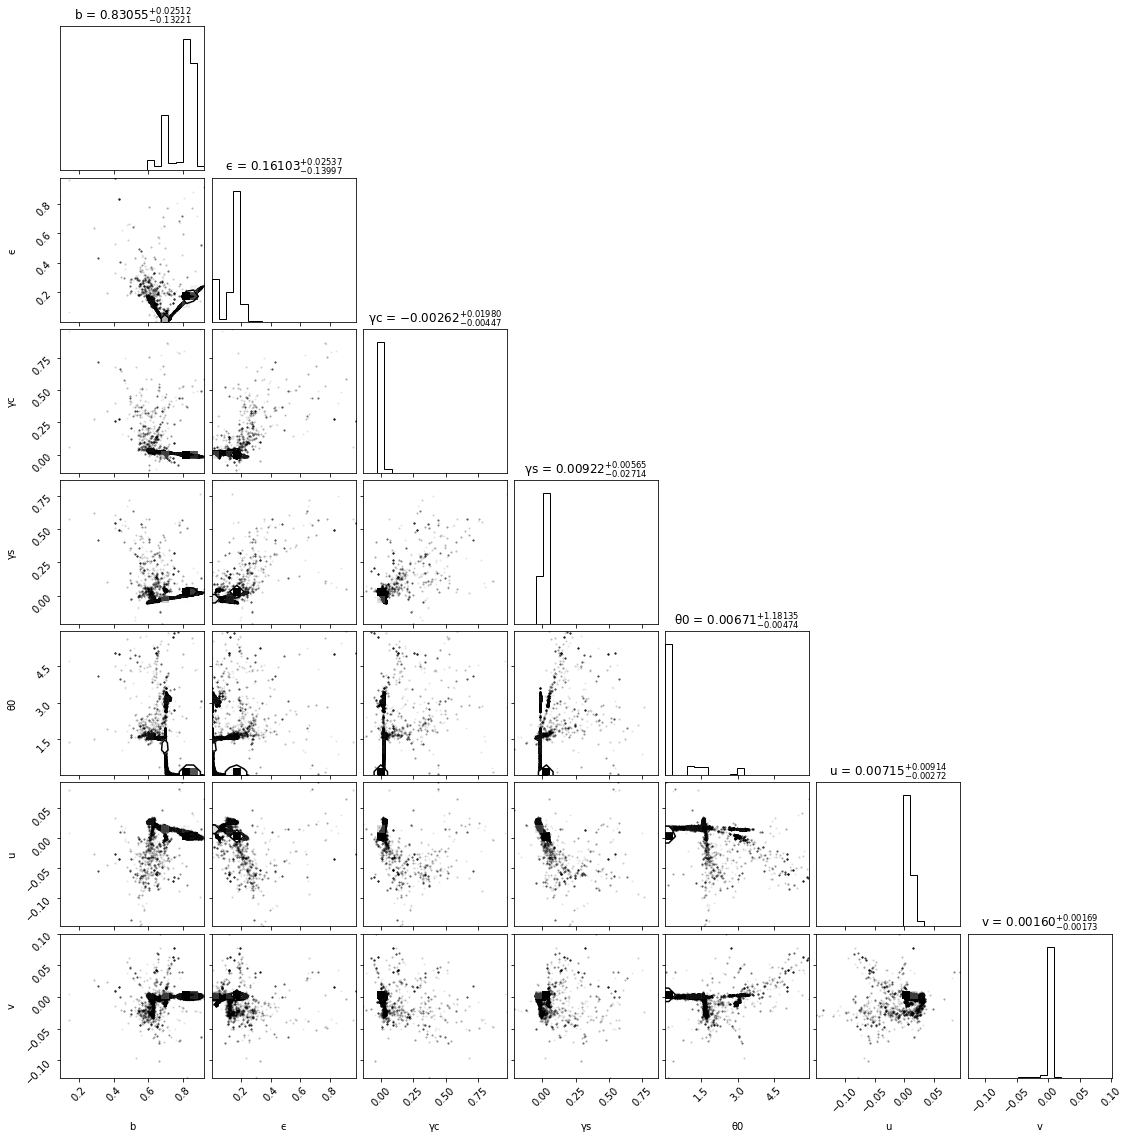

In [65]:
fig = corner.corner(samples,show_titles=True,labels=('b','ϵ','γc','γs','θ0','u','v'), title_fmt='.5f')
fig.show()

In [70]:
lnprob(samples[-1,:], newData[0])

-22.04830767033838

In [68]:
def plot_chi2(x, y, b, eps, gc, gs, theta0, u, v):
    rtheta = cart2pol(x,y)
    return (x - dxphi(rtheta, b, eps, gc, gs, theta0) - u)**2 + (y - dyphi(rtheta, b, eps, gc, gs, theta0) - v)**2

def plot_model(data, samples):
    data = data[0:2].T
    xyimg = pol2cart(data[:,0], data[:,1])
    b, eps, gc, gs, theta0, u, v = samples[-1,:]
    sqrlim = 1
    levels = np.arange(-8, 0, 0.5)
    x = np.linspace(-sqrlim, sqrlim, 500)
    y = np.linspace(-sqrlim, sqrlim, 500)
    xx,yy = np.meshgrid(x,y)
    zz = plot_chi2(xx, yy, b, eps, gc, gs, theta0, u, v)

    imgfig, ax = plt.subplots(figsize=(14,14))
    c = ax.contour(xx, yy, np.log10(zz), levels=levels, zorder=0)
    cb = plt.colorbar(c, ax=ax)
    ax.set_aspect('equal', adjustable='box')
    imgs = ax.scatter(xyimg[0], xyimg[1], color='k', marker=(5,1,0), s=300, zorder=1)
    plt.show()

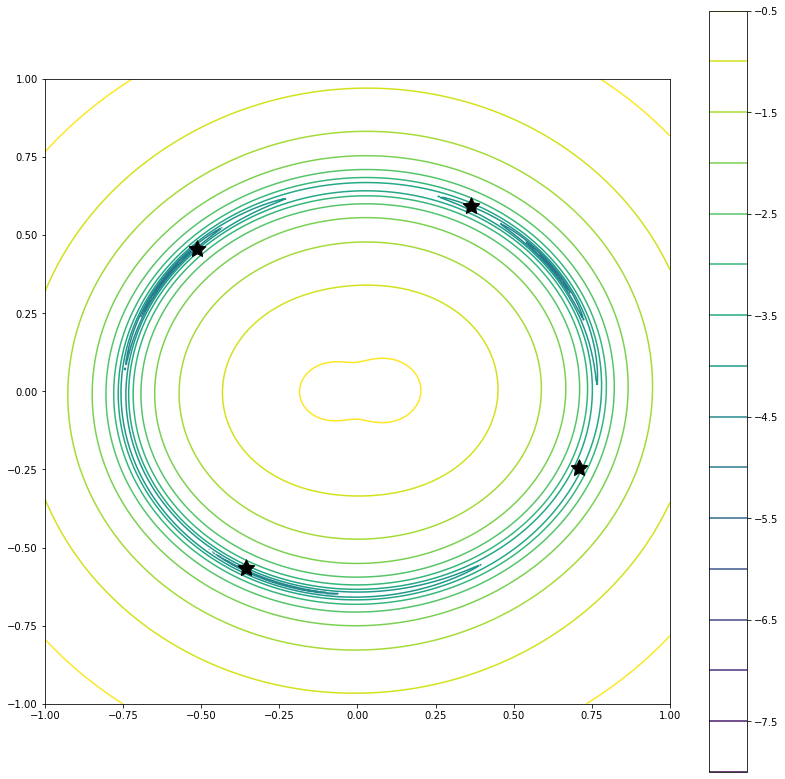

In [69]:
plot_model(data = newData[0], samples=samples)

## debugging using the roots practical as test data

In [56]:
# creating rthetasigma
imgxy = np.array([[-7.728e-01,+2.924e-04], [+1.045e+00,+1.135e-05], [+7.500e-01,+8.199e-01], [+7.500e-01,-8.199e-01]])
print(imgxy)
imgrth = np.array(cart2pol(imgxy[:,0], imgxy[:,1]))
print(imgrth)
imgrthsgm = np.concatenate((imgrth, [np.ones(4)]))
print(imgrthsgm)

[[-7.728e-01  2.924e-04]
 [ 1.045e+00  1.135e-05]
 [ 7.500e-01  8.199e-01]
 [ 7.500e-01 -8.199e-01]]
[[ 7.72800055e-01  1.04500000e+00  1.11118676e+00  1.11118676e+00]
 [ 3.14121429e+00  1.08612440e-05  8.29893904e-01 -8.29893904e-01]]
[[ 7.72800055e-01  1.04500000e+00  1.11118676e+00  1.11118676e+00]
 [ 3.14121429e+00  1.08612440e-05  8.29893904e-01 -8.29893904e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


c:\python3_7_9\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


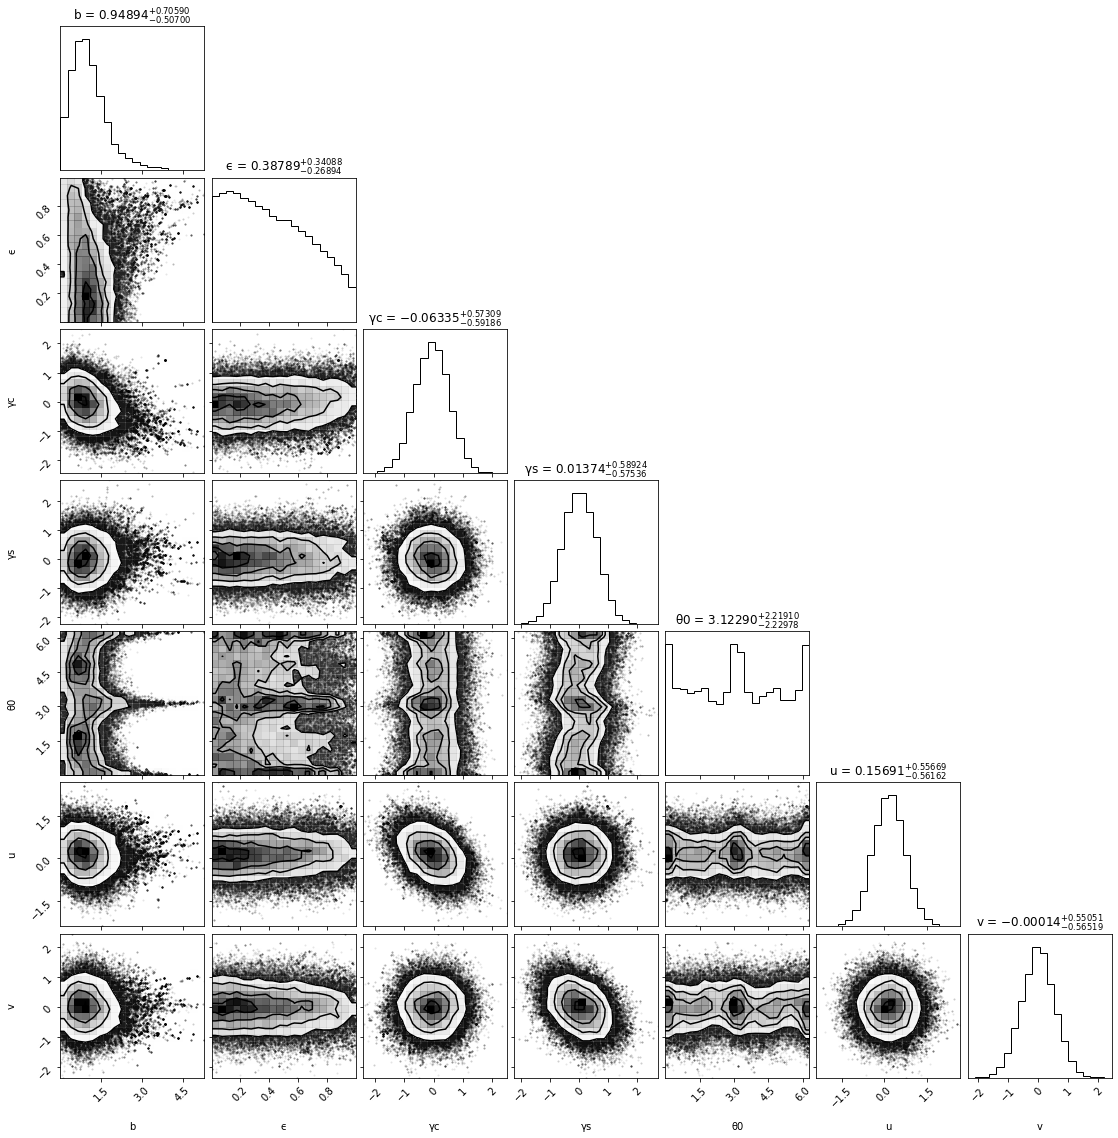

In [57]:
try: samples = mcmc_model(imgrthsgm, nburn=5000, nmain=10000)
except: samples = mcmc_model(imgrthsgm, nburn=5000, nmain=10000)
fig = corner.corner(samples,show_titles=True,labels=('b','ϵ','γc','γs','θ0','u','v'), title_fmt='.5f')
fig.show()

In [58]:
lnprob(samples[-1,:], imgrthsgm)

-3.190863574921983

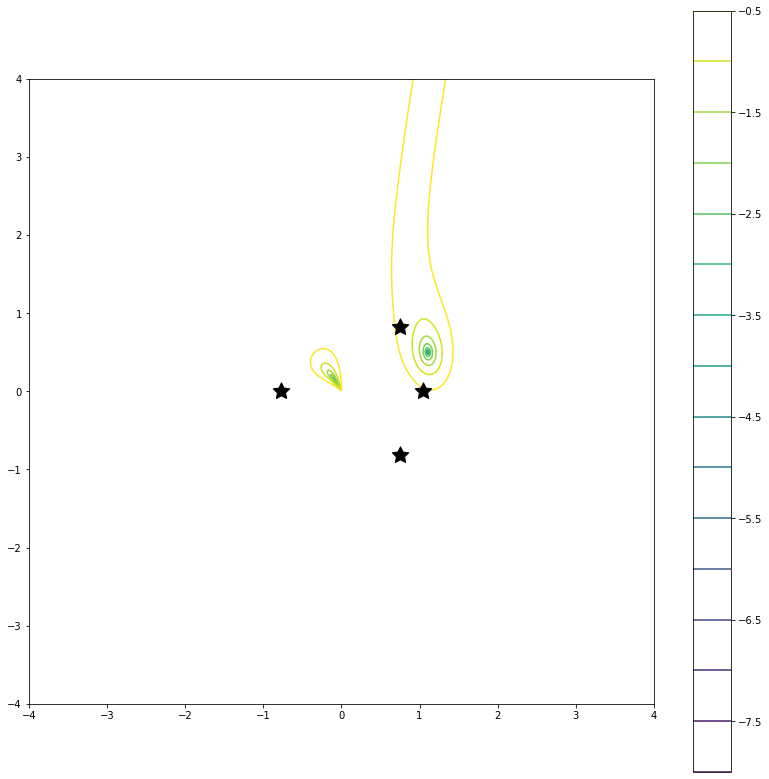

In [61]:
plot_model(imgrthsgm, samples)